# Embedding Module - DL & & GenAI Project Course [BSDA2001P], IIT Madras

Created by: Indranil Bhattacharyya


* **Kaggle Compettion:** Natural Language Processing with Disaster Tweets
* **Objective:** Predict which Tweets are about real disasters and which ones are not
* **Dataset used in this notebook:** [Data](https://https://www.kaggle.com/competitions/nlp-getting-started/data)

In [1]:
!unzip "/content/nlp-getting-started.zip"

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [33]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


To Downlad Glove Weights

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# TF-IDF Embedding:

In [ ]:
def get_tfidf_embeddings(texts, max_features=5000):
    """
    Generate TF-IDF embeddings for a list of text samples.
    Returns a dense numpy array of shape (n_samples, n_features).
    """
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    X_tfidf = vectorizer.fit_transform(texts)
    return X_tfidf.toarray(), vectorizer


# Glove Embedding:

In [ ]:
!pip install -q gensim

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
def get_glove_embeddings_gensim(texts, glove_path="glove.6B.100d.txt"):
    """
    Generate average GloVe embeddings for each text using Gensim.
    Automatically converts GloVe format to Word2Vec if needed.
    """
    word2vec_output_file = "glove.6B.100d.word2vec.txt" # you can use higher dimensional embedding if you want

    # Convert if not already done
    if not os.path.exists(word2vec_output_file):
        print("Converting GloVe format to Word2Vec format...")
        glove2word2vec(glove_path, word2vec_output_file)

    print("Loading vectors via Gensim...")
    model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

    def embed_sentence(sentence):
        words = [w for w in sentence.split() if w in model]
        if not words:
            return np.zeros(model.vector_size)
        return np.mean(model[words], axis=0)

    embeddings = np.array([embed_sentence(t) for t in texts])
    return embeddings


# Transformer based model embedding:

Where to find transformer based models:


1.   Go to https://huggingface.co/models
2.   Select `Tasks`
3.   Select the appropiate task from the `Natural Language Processing` Category
4.   Example: https://huggingface.co/Qwen/Qwen3-Embedding-0.6B, Go Through the model page to know more about the model, how it works, when to choose it, how to use it etc...


In [ ]:
def get_bert_embeddings(texts, model_name="all-MiniLM-L6-v2"):
    """
    Generate sentence embeddings using a pre-trained BERT (SentenceTransformer) model.
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)
    return embeddings

In [8]:
# Suppose df is your dataset
sample_df = train_df.sample(10)
texts = sample_df["text"].fillna("").tolist()


tfidf_embeds, vectorizer = get_tfidf_embeddings(texts, max_features=100)
glove_embeds = get_glove_embeddings_gensim(texts, glove_path="/content/glove.6B.100d.txt")
bert_embeds = get_bert_embeddings(texts)


Converting GloVe format to Word2Vec format...


/tmp/ipython-input-1015480770.py:34: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


Loading vectors via Gensim...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Choosing the Right Text Representation: A Practical Guide

In our session, we explored the evolution of representing text for machine learning models, covering four main categories:

* ***Traditional Embeddings***: Methods like **Bag-of-Words (BoW)** and **TF-IDF** that rely on word counts and frequencies.
* ***Dense and Distributed Representations***: Foundational neural embeddings like **Word2Vec** and **GloVe** that capture semantic relationships between words.
* ***Transformer-Based Embeddings***: Context-aware embeddings from models like **BERT**, which understand a word's meaning based on its surrounding words.
* ***Transformer-Based Embeddings with MRL***: Advanced techniques (Multiple Representation Learning) that can capture even finer nuances.

This leads to a crucial question: **How do we know which representation to use for a given task?**

While the ultimate answer depends on your specific application, performance metrics, and computational resources, we can develop a strong intuition by running a quick "sanity check."

---

### A Proxy for Evaluating Embedding Quality

We can devise a simple experiment to quickly assess how well an embedding method captures the *semantic meaning* of a sentence.

#### The Hypothesis

Our core idea is based on a simple hypothesis:

> A good embedding model should generate vectors that are close together in high-dimensional space for semantically similar sentences. Conversely, for sentences that are dissimilar in meaning, their vectors should be far apart.

In other words, the geometric distance between two vectors should reflect the semantic similarity between the two sentences they represent.

#### Measuring Similarity: Cosine Similarity

To measure how "close" two vectors are in a high-dimensional space, we won't use a standard distance metric like Euclidean distance. Instead, we'll use **Cosine Similarity**.

Cosine Similarity measures the cosine of the angle between two non-zero vectors. It essentially tells us if the vectors are pointing in the same direction, irrespective of their magnitude.

* A cosine similarity of **1** means the vectors point in the exact same direction (highly similar).
* A cosine similarity of **0** means the vectors are orthogonal, or completely unrelated.
* A cosine similarity of **-1** means the vectors point in opposite directions (highly dissimilar).

The formula is:
$$\text{cosine_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$$

If the cosine similarity score is high (close to 1), we can infer that the sentences are similar according to the model.

---

### Let's Set Up Our Experiment

We will test our hypothesis with two distinct pairs of sentences:

1.  **A Semantically Similar Pair:** These sentences use different words but convey the same meaning. This tests the model's ability to understand concepts beyond simple keyword matching.
    * **Sentence A:** `The cat sat on the mat.`
    * **Sentence B:** `A feline was resting on the rug.`

2.  **A Semantically Dissimilar Pair:** These sentences are on completely different topics.
    * **Sentence C:** `The cat sat on the mat.`
    * **Sentence D:** `Quantum computing could revolutionize science.`

#### Expected Outcome

By applying different embedding techniques to these sentences and calculating the cosine similarity, we expect to see:

* `cosine_similarity(A, B)` should be **high** (closer to 1).
* `cosine_similarity(C, D)` should be **low** (closer to 0).

By comparing the scores produced by TF-IDF, Word2Vec, and BERT, we can gain valuable insight into their strengths and weaknesses in capturing true semantic meaning.

Now, let's put this into practice! In the following cells, we will implement this test for the different embedding types we've learned.

In [34]:
similar_pair_1 = 'The cat sat on the mat.'
similar_pair_2 = 'A feline was resting on the rug.'


dissimilar_pair_1 = "The cat sat on the mat."
dissimilar_pair_2 = 'Quantum computing could revolutionize science.'

**TF-IDF Embedding:**

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# Define the two sentences


# 1. Transform the new sentences using the existing vectorizer
tfidf_a = vectorizer.transform([similar_pair_1])
tfidf_b = vectorizer.transform([similar_pair_2])

# 2. Calculate Cosine Similarity
# cosine_similarity expects matrices, so we use the [0] to get the scalar result
tfidf_similarity_similar = cosine_similarity(tfidf_a, tfidf_b)[0][0]



# 1. Transform the new sentences using the existing vectorizer
tfidf_a = vectorizer.transform([dissimilar_pair_1])
tfidf_b = vectorizer.transform([dissimilar_pair_2])

# 2. Calculate Cosine Similarity
# cosine_similarity expects matrices, so we use the [0] to get the scalar result
tfidf_similarity_dis_similar = cosine_similarity(tfidf_a, tfidf_b)[0][0]




print(f"Sentence Similarity (Similar Pair)     : {tfidf_similarity_similar.item():.4f}")
print(f"Sentence Similarity (Dissimilar Pair) : {tfidf_similarity_dis_similar.item():.4f}")

Sentence Similarity (Similar Pair)     : 0.0000
Sentence Similarity (Dissimilar Pair) : 0.0000


**Glove Embedding:**

**Word2Vec:**
Learns embeddings by context prediction — “If a word appears near these words, it should have a similar vector.”
→ Focuses more on local semantic relationships.

**GloVe:**
Learns embeddings by analyzing the overall co-occurrence frequencies across the entire corpus.
→ Captures global statistical structure.


| Criteria                  | **Word2Vec**                                | **GloVe**                                                         |
| ------------------------- | ------------------------------------------- | ----------------------------------------------------------------- |
| Accuracy on analogy tasks | Slightly better on smaller corpora          | Better on large corpora (Wikipedia, Common Crawl)                 |
| Training Speed            | Faster (with negative sampling)             | Slower (requires building co-occurrence matrix)                   |
| Interpretability          | Less transparent                            | Easier to interpret due to matrix factorization                   |
| Coverage                  | Depends on training corpus                  | Trained on very large corpora (Stanford GloVe pre-trained models) |
| Rare Words                | Can handle better if trained on enough data | Can struggle if rare words have few co-occurrences                |


In [43]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


sentences_to_embed = [similar_pair_1, similar_pair_2]
glove_embeds_new = get_glove_embeddings_gensim(sentences_to_embed, glove_path="/content/glove.6B.100d.txt")

# The result should be a list/array of two vectors
glove_a = glove_embeds_new[0].reshape(1, -1) # Reshape for cosine_similarity
glove_b = glove_embeds_new[1].reshape(1, -1)

# Calculate Cosine Similarity
glove_similarity_similar = cosine_similarity(glove_a, glove_b)[0][0]



sentences_to_embed = [dissimilar_pair_1, dissimilar_pair_2]
glove_embeds_new = get_glove_embeddings_gensim(sentences_to_embed, glove_path="/content/glove.6B.100d.txt")

# The result should be a list/array of two vectors
glove_a = glove_embeds_new[0].reshape(1, -1) # Reshape for cosine_similarity
glove_b = glove_embeds_new[1].reshape(1, -1)

# Calculate Cosine Similarity
glove_similarity_dis_similar = cosine_similarity(glove_a, glove_b)[0][0]




print(f"Sentence Similarity (Similar Pair)     : {glove_similarity_similar.item():.4f}")
print(f"Sentence Similarity (Dissimilar Pair) : {glove_similarity_dis_similar.item():.4f}")

Loading vectors via Gensim...
Loading vectors via Gensim...
Sentence Similarity (Similar Pair)     : 0.9111
Sentence Similarity (Dissimilar Pair) : 0.4237


**Transformer-Based Models:**

To know more about this model, please refer to this: [Click Here](https://https://huggingface.co/sentence-transformers/all-mpnet-base-v1)

In [41]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')


sent1, sent2 = "I went to the bank of the river.", "I deposited money in the bank."

emb1, emb2 = model.encode([similar_pair_1, similar_pair_2], convert_to_tensor=True)
sim_pair_similarity_transformer = util.cos_sim(emb1, emb2)

emb1, emb2 = model.encode([dissimilar_pair_1, dissimilar_pair_2], convert_to_tensor=True)
dis_sim_pair_similarity_transformer  = util.cos_sim(emb1, emb2)

print(f"Sentence Similarity (Similar Pair)     : {sim_pair_similarity_transformer.item():.4f}")
print(f"Sentence Similarity (Dissimilar Pair) : {dis_sim_pair_similarity_transformer.item():.4f}")


Sentence Similarity (Similar Pair)     : 0.7266
Sentence Similarity (Dissimilar Pair) : 0.0031


Quick question — why do you think TF-IDF gave a similarity score of 0 for both pairs?
If you’re not sure, try revisiting the session once more!

## From Embeddings to Insights: Building Your First Sentiment Classifier

By now, I hope you've grasped how text representations work (if not, please revisit the session or ask on Discourse!). You've had first-hand experience creating these representations and comparing them on a sentence similarity task.

But the real question is, how do you use this powerful knowledge to build something practical, like a **sentiment classifier**? 🧐

---

### Your Blueprint for a Sentiment Classifier 📝

If you're still unsure how to get started on your project or make your first submission, don't worry! Here is a simple, step-by-step recipe to build a sentiment classifier by incorporating everything you've learned.

Think of this as your guide from raw text to a final prediction. This process is a foundational pipeline in Natural Language Processing.



#### **Step 1: Data Preparation & Preprocessing**
Before you can create embeddings, your text needs to be cleaned. This is a crucial first step.
* **Load your dataset:** Get your text data (e.g., movie reviews) and corresponding labels (e.g., positive/negative).
* **Clean the text:** Perform standard text cleaning like converting to lowercase, removing punctuation, and handling stop words.
* **Split your data:** Divide your dataset into a **training set** (to teach the model) and a **testing set** (to evaluate its performance on unseen data).

---

#### **Step 2: Feature Extraction (The Embedding Step!)**
A machine learning model can't understand words; it understands numbers. This is where your new knowledge comes into play. You need to convert your cleaned text into numerical vectors.
* **Choose your embedding strategy:** Will you use **TF-IDF**, a pre-trained **Word2Vec** model, or a powerful **Transformer-based** embedding like BERT?
* **Transform your text:** Apply your chosen method to both your training and testing sets to create your feature vectors (`X_train`, `X_test`).

---

#### **Step 3: Model Training**
With your text now represented as numbers, you can use any standard machine learning classifier.
* **Select a model:** Start with something simple and effective, like **Logistic Regression**, **Naive Bayes**, or a **Support Vector Machine (SVM)**.
* **Train the model:** Fit your chosen model on your training data. The model will learn the patterns that map your text vectors (`X_train`) to their sentiment labels (`y_train`).
    * `model.fit(X_train, y_train)`

---

#### **Step 4: Evaluation**
How good is your model? You'll find out by testing it on the data it has never seen before.
* **Make predictions:** Use your trained model to predict the sentiment of the test set (`X_test`).
* **Measure performance:** Compare the model's predictions to the true labels (`y_test`) using standard metrics like **Accuracy**, **Precision**, **Recall**, and the **F1-Score**.

This simple recipe is your starting point. You can experiment by swapping out different embedding methods in Step 2 or different classifiers in Step 3 to see how it impacts your final performance.

Now you have the blueprint. There's no excuse to defer that project to the next term, is there? Let's get building!

In [45]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:

texts = train_df["text"].fillna("").tolist()


bert_embeds = get_bert_embeddings(texts, model_name="sentence-transformers/all-mpnet-base-v1")

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

In [51]:
X = bert_embeds
y = train_df["target"]

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       874
           1       0.83      0.76      0.80       649

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.83      1523
weighted avg       0.83      0.83      0.83      1523



Excellent result. This is a powerful demonstration of a core principle in modern machine learning: an advanced representation paired with a simple model can achieve outstanding performance.

The sophisticated all-mpnet-base-v1 embeddings are doing the heavy lifting by capturing the rich semantic meaning of the text. This allows a computationally efficient and simple model like Logistic Regression to achieve a remarkable and well-balanced 83% F1-score.

This approach highlights that the quality of your feature representation is often the most critical factor for success. The model's primary challenge is the slightly lower recall for class 1, but this can be addressed with further fine-tuning. The foundational strategy is clearly a winning one.

## 📈 Conclusion

**Congratulations** on making it through this guide! You've successfully bridged the gap between the theory of text representation and its practical application in a machine learning pipeline.

Here are the key takeaways from this session:

* You learned that not all text embeddings are created equal. We have a practical method—using cosine similarity—to quickly evaluate how well an embedding captures semantic meaning.

* You now have a foundational, reusable 4-step blueprint for nearly any NLP classification task: Data Prep -> Feature Extraction (Embedding) -> Model Training -> Evaluation.

* You understand that the choice of embedding is a critical "feature engineering" step that directly impacts your model's performance.

* You are now equipped with the fundamental skills and a clear plan to begin tackling your main course project.

## 📝 Homework: Applying Your Knowledge
Your task is to take the blueprint from this notebook and apply it to your own project. This is the first and most important step in moving from theory to a successful project submission.

**Your assignment:**

* Implement the Pipeline: Apply the complete 4-step pipeline (preprocess, embed, train, evaluate) to your project's dataset.

* Establish a Baseline: Start with a simple combination, such as TF-IDF for embeddings and Logistic Regression for the model. This will be your baseline performance.

* Experiment: Swap out the embedding method. Try at least one other representation (e.g., a pre-trained Word2Vec model or a Transformer-based embedding) and see how it affects your evaluation metrics.

### A Crucial Note on Problem-Solving
As you implement this, you will inevitably run into errors, bugs, and unexpected issues. This is a normal and essential part of the learning process.

Your challenge is to solve these issues by referring to official documentation first, not by using AI assistants like ChatGPT or Gemini.

The goal here is to build a core engineering skill: learning to debug and find solutions independently. Reading documentation from libraries like scikit-learn, pandas, or Hugging Face is a fundamental skill that will serve you throughout your career. Treat it as part of the assignment!



# Exploration - Extra:

## Visualizing Semantic Space
This t-SNE plot offers a powerful geometric confirmation of our model's understanding by projecting high-dimensional embeddings into a visible 3D space.

High Similarity (Green Line): The two sentences about the cat are mapped to points very close together, visually representing their semantic connection.

Low Similarity (Red Line): The sentences about the cat and quantum computing are pushed far apart, showing they are unrelated.

In essence, the visualization proves the model has learned a meaningful space where geometric distance corresponds to semantic similarity.

To explore further, try plotting hundreds of sentences to see topic clusters emerge, or compare plots from different embedding models (like TF-IDF vs. BERT) to visually gauge their quality.

In [58]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

similar_pair_1 = 'The cat sat on the mat.'
similar_pair_2 = 'A feline was resting on the rug.'


dissimilar_pair_1 = "The cat sat on the mat."
dissimilar_pair_2 = 'Quantum computing could revolutionize science.'

emb1, emb2 = model.encode([similar_pair_1, similar_pair_2], convert_to_tensor=True)

emb3, emb4 = model.encode([dissimilar_pair_1, dissimilar_pair_2], convert_to_tensor=True)


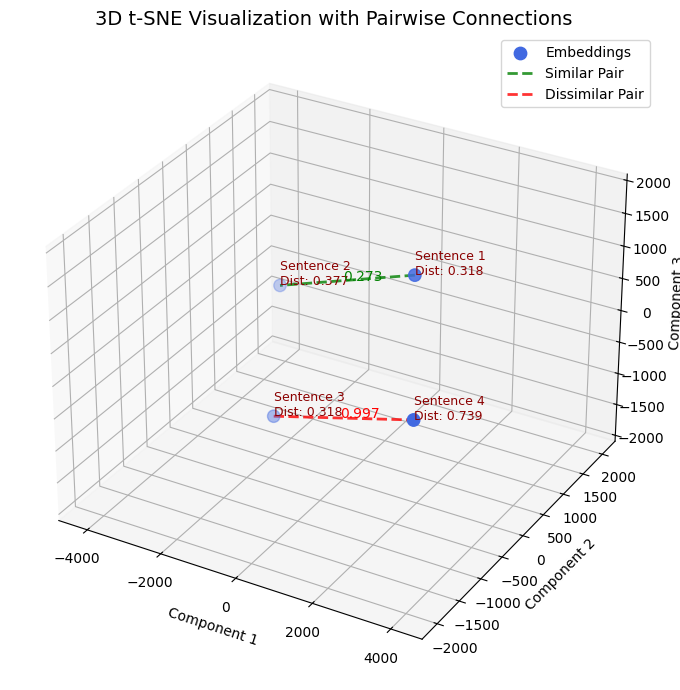

In [66]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


data = np.vstack([emb1, emb2, emb3, emb4])
labels = ["Sentence 1", "Sentence 2", "Sentence 3", "Sentence 4"]

similarity_matrix = cosine_similarity(data)
distance_matrix = 1 - similarity_matrix


tsne = TSNE(
    n_components=3,
    learning_rate='auto',

    perplexity=1
)
X_embedded = tsne.fit_transform(data)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2],
           s=80, c='royalblue', label='Embeddings')

for i, label in enumerate(labels):
    avg_dist = np.mean(distance_matrix[i, :])
    annotation = f"{label}\nDist: {avg_dist:.3f}"
    ax.text(
        X_embedded[i, 0],
        X_embedded[i, 1],
        X_embedded[i, 2],
        annotation,
        fontsize=9,
        color='darkred'
    )


similar_pairs = [(0, 1)]      # (Sentence 1, Sentence 2)
dissimilar_pairs = [(2, 3)]   # (Sentence 3, Sentence 4)

# Green dashed lines for similar pairs
for i, j in similar_pairs:
    ax.plot(
        [X_embedded[i, 0], X_embedded[j, 0]],
        [X_embedded[i, 1], X_embedded[j, 1]],
        [X_embedded[i, 2], X_embedded[j, 2]],
        color='green', linestyle='--', linewidth=2, alpha=0.8,
        label='Similar Pair' if i == 0 else ""
    )
    dist = distance_matrix[i, j]
    mid = (X_embedded[i] + X_embedded[j]) / 2
    ax.text(mid[0], mid[1], mid[2], f"{dist:.3f}", color='green')

# Red dashed lines for dissimilar pairs
for i, j in dissimilar_pairs:
    ax.plot(
        [X_embedded[i, 0], X_embedded[j, 0]],
        [X_embedded[i, 1], X_embedded[j, 1]],
        [X_embedded[i, 2], X_embedded[j, 2]],
        color='red', linestyle='--', linewidth=2, alpha=0.8,
        label='Dissimilar Pair' if i == 2 else ""
    )
    dist = distance_matrix[i, j]
    mid = (X_embedded[i] + X_embedded[j]) / 2
    ax.text(mid[0], mid[1], mid[2], f"{dist:.3f}", color='red')

ax.set_title("3D t-SNE Visualization with Pairwise Connections", fontsize=14)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.legend()

plt.tight_layout()
plt.show()
